# Tutorial 5a: Generative models and random number generation

(c) 2018 Justin Bois. With the exception of pasted graphics, where the source is noted, this work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

This document was prepared at [Caltech](http://www.caltech.edu) with financial support from the [Donna and Benjamin M. Rosen Bioengineering Center](http://rosen.caltech.edu).

<img src="caltech_rosen.png">

*This document was generated from a Jupyter notebook.  You can download the notebook [here](t5a_generative_models_and_rng.ipynb).*

In [1]:
import numpy as np
import pandas as pd
import scipy.special
import scipy.stats as st

import pystan

import bebi103

import altair as alt
import altair_catplot as altcat

import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()

Loading BokehJS ...

## Thinking generatively

As we start thinking about statisical modeling, I remind you that we will be thinking **generatively**. To clarify what I mean by this, it might be useful to have a concrete example in mind. Image I measure the cross-sectional area of a collection of *C. elegans* egg over and over again. This is exactly what was done by [Harvey and Orbidans, *PLoS ONE*, **6**(10): e25840](doi:10.1371/journal.pone.0025840), and we will look at their data set in a moment. In making the measurements, you are **drawing samples** out of a probability distribution. We do not know what that distribution is, but for a moment, let us assume it is a Gaussian distribution with mean of 2000 µm² and a standard deviation of 200 µm². For any given measurement, we would be more likely to measure a cross sectional area of 2000 µm² than one of 2500 µm². We would have virtually no chance of measuring a cross sectional area of 3000 µm². So, each measurement is like drawing a random number out of an underlying probability distribution; some values are more probable to be drawn than others.

We could build a **statistical model** for the probability distribution from which the data are drawn. This is called a **generative model**. A reasonable model for the egg cross-sectional area is that they are drawn from a Gaussian distribution. We could then write down the probability density function for the measured cross-sectional area, $x$, as

\begin{align}
f(x;\mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\,\exp\left[-\frac{(x-\mu)^2}{2\sigma^2}\right],
\end{align}

and a CDF of

\begin{align}
F(x;\mu,\sigma) = \frac{1}{2}\left(1 + \mathrm{erf}\left(\frac{x-\mu}{\sqrt{2}\,\sigma}\right)\right),
\end{align}

where erf denotes the error function, and $\mu$ is the mean cross-section area (2000 µm²) and $\sigma$ is the standard deviation (200 µm²). We could then have an idea of how we might expect out measured data to look.

## Using scipy.stats for probability distributions


Since we would plot an ECDF of our data, we can plot the CDF of the generative model to see what we might expect our measured data to look like.

In [2]:
# Parameters (in units of µm²)
mu = 2000
sigma = 200

# x and y values for plot
x = np.linspace(1000, 3000, 400)
cdf = (1 + np.erf((x-mu) / (np.sqrt(2) * sigma))) / 2

# Plot the figure
p = bokeh.plotting.figure(
    height=200,
    width=350,
    x_axis_label='cross sectional area (µm²)',
    y_axis_label='CDF',
    x_range=[1000, 3000])
p.line(x, cdf, line_width=2)

bokeh.io.show(p)

In the above, coding up the CDF can be a bit annoying (and so could coding up the PDF, if we wanted to). Fortuantely, for many named distributions, the CDF and PDF are built in to the `scipy.stats` module, which I have imported here as `st`. We can make the same plot using the built-in CDF.

In [3]:
# Use scipy.stats to get CDF
st.norm.cdf(x, mu, sigma)

# Plot the figure
p = bokeh.plotting.figure(
    height=200,
    width=350,
    x_axis_label='cross sectional area (µm²)',
    y_axis_label='CDF',
    x_range=[1000, 3000])
p.line(x, st.norm.cdf(x, mu, sigma), line_width=2)

bokeh.io.show(p)

I will discuss the general syntax for using distributions from the `scipy.stats` module using the Gaussian (Normal) distribution as an example. `st.norm` invokes the Normal distribution. `st.norm` has many methods and attributes. The three that we will most often use in this course are `st.norm.pdf()`, `st.norm.cdf()`, and `st.norm.rvs()`. 

#### Computing PDFs and PMFs

I will first demonstrate how to obtain the values of the PDF $f(x)$ for the distribution for specified values of $x$. There are two ways to do this. First, you can instantiate an object that defines a Normal distribution with fixed parameters, and then use the `.pdf()` method of that instance. For the present example, we could do this as follows.

In [4]:
# Instantiate instance with set µ and σ
norm = st.norm(2000, 200)

# Compute the values of the pdf at x (which may be an array)
pdf_values = norm.pdf(x)

Alternatively, we can directly call `st.norm.pdf()` with `x` as the first argument, followed by the parameters for the distribution.

In [5]:
pdf_values = st.norm.pdf(x, 2000, 200)

For a discrete distribution, there is no `pdf()` method, but rather a `pmf()` method for the probability mass function. It syntax is exactly as for the PDF. We will use the PDF and PMF functionality of `scipy.stats` when we are doing Bayesian parameter estimation by optimization, so you might want to refer back to this syntax when we start doing that. Note how convenient this is; you do not have to type out the mathematical form of the PDF/PMF. To do your statistical modeling, you just need to know the stories of the distributions and then you can use the `scipy.stats` module to do the mathematics for you.

### Computing CDFs

Computing the CDF is done in exactly the same way as the PDF.

In [6]:
# Instantiate, then compute
norm = st.norm(2000, 200)
cdf_values = norm.cdf(x)

# Or, just directly use st.norm.cdf()
cdf_values = st.norm.cdf(x, 2000, 200)

### Sampling out of the distribution

If we want to draw random samples out of a distribution, we use the `rvs()` method. Importantly, it has a `size` kwarg that allows you to specify how many samples you want to draw. As with the `pdf()` and `cdf()` methods, there are also two ways to draw random samples. You can first instantiate the distribution and use the `rvs()` method, or you can directly use, e.g., `st.norm.rvs()`. To demonstrate, I will draw random samples and then plot the ECDF of the random samples, which you will see look very much like the CDF of the distribution from which they are drawn.

In [7]:
# Instantiate and draw
norm = st.norm(2000, 200)
samples = norm.rvs(size=700)

# Plot the ECDF
p = bebi103.viz.ecdf(samples, x_axis_label='x (µm²)')
p.line(x, cdf_values, color='orange', line_width=2)
bokeh.io.show(p)

And, as you may have guessed, we could also draw the samples as follows.

In [8]:
samples = st.norm.rvs(2000, 200, size=700)

### A note on parametrization

As you can imagine, there are different ways of parametrizing the same distribution. For example, we could define the PDF for the Exponential distribution as

\begin{align}
f(x;\beta) = \beta\, \mathrm{e}^{-\beta x},
\end{align}

or as

\begin{align}
f(x;\tau) = \tau^{-1}\, \mathrm{e}^{-x/\tau}.
\end{align}

For this course, we are using the parametrization that [Stan](http://mc-stan.org/) uses, which may be different from what Scipy or Numpy use. Refer to [the tutorial on probability stories](t3c_probability_stories.html) to make sure you know how to set the parameters for Scipy (and Numpy, which we will introduce momentarily) so that everything matches up with Stan.

## Sampling out of distributions with Numpy

While `scipy.stats` is very useful for computing PDFs, PMFs, and CDFs, I find that the sampling capabilities of Numpy's `random` module is more convenient and has better performance than using the `rvs()` method in `scipy.stats`. The syntax is similar to Scipy, with some differences in the names of the distributions (e.g.,  it's `np.random.normal()` whereas it's `scipy.stats.norm`) and in the parametrizations (again, refer to [the tutorial on probability stories](t3c_probability_stories.html)). To sample out of a Normal distribution as we did before using Numpy, do the following.

In [9]:
samples = np.random.normal(2000, 200, size=700)

## Sampling out of distributions with Stan

*Read at the end of this tutorial about installing Stan. You will obviously need to do that to run this part of the tutorial, but I do not want to interrupt our discussion of sampling with that here.*

This is our first introduction to [Stan](http://mc-stan.org/), a **probabilistic programming language** that we will use for much of our statistical modeling. Stan is a separate language. It has a command line interface and interfaces for R and Python. It also have interfaces to Julia, Matlab, Stata, Scala, and Mathematica, though these five interfaces are currently just wrappers around the command line interface.

We will be using the Python interface, [PyStan](https://pystan.readthedocs.io). Remember, though, that Stan is a separate langauge, and any Stan program you write works across all of these interfaces.

Before we dive in and write our first Stan program to draw samples out of the Normal distribution, I want to tell you a few things about Stan.

1. The [Stan language module](http://mc-stan.org/users/documentation/index.html) will be a very good friend of yours.
2. A Stan program is compiled. The Stan compiler, `stanc` translates the Stan program into C++, and then that is compiled using whatever your system C++ compiler is.
3. The index origin of Stan is `1`, not `0` as in Python.
4. Stan is strongly statically typed, which means that you need to declare the data type of a variable explicitly before using it.
5. All Stan commands must end with a semicolon.
6. Blocks of code are separated using curly braces.

Let's just go ahead and write our first Stan program to generate $N$ samples out of a Gaussian distribution with a specified mean and variance. The first thing we'll do it write the Stan code. For now, we will store it as a multiline Python string.

In [10]:
stan_code = """
data {
  real mu;
  real sigma;
}


generated quantities {
 real samples;

  samples = normal_rng(mu, sigma);
}
"""

# Print it so it looks prettier
print(stan_code)


data {
  real mu;
  real sigma;
}


generated quantities {
 real samples;

  samples = normal_rng(mu, sigma);
}



Note that there are two **blocks** in this particular Stan code, the `data` block and the `generated quantities` block. These are two of the seven possible blocks in a Stan code, and we will explore others later on in the course. The `data` block contains anything that a user wants to input into the program. In our case, we want to input `mu`, the mean of the Normal distribution we want to draw from, and `sigma`, its standard deviation. We declare these in the `data` block, and we pass them in as a Python dictionary when we do the sampling.

In the `generated quantities` block, we have code for what we want the Stan program to generate, in this case, the samples.

Now that we have our code, we can use PyStan to compile it into a `StanModel`, which is a Python object that contains the compiled Stan executable that enables us to conveniently use Python syntax to use.

In [11]:
sm = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ea347256464b0208c5a018b46c1801b NOW.
/Users/Justin/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/y7/r162f1fd0zv1vzxkb5nktz300000gn/T/tmp8ksz0jod/stanfit4anon_model_9ea347256464b0208c5a018b46c1801b_742895323532487913.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


That took a while to compile. We might like to avoid recompiling a model if we have already compiled it. If you want to have that functionality, instead compile using

In [12]:
sm = bebi103.stan.StanModel(model_code=stan_code)

Using cached StanModel.


This function pickles the `StanModel` object (essentially stores the Python object in your pwd) after it is compiled. Whenever we ask to compile again, it first checks to see if the model has already been compiled. If not (or if anything at all in the model has changed), the model is compiled.

To sample, we need to construct a data dictionary to pass into the sampler. We need to specify values for each entry of the `data` block of the Stan program. Note that I am careful to get the data types right. I specify `mu` to be `2000.0`, not `2000`, since `mu` is specified to be `real`, the Stan equivalent of the Python `float`.

In [13]:
data = dict(mu=2000.0, sigma=200.0)

Now we are ready to draw the samples. For this kind of sampling, we need to specify the algorithm as `Fixed_param`. This means that Stan is not to do any of its fancy MCMC (which we will use heavily later in the course), but simply to execute the code in the `generated quantities` block. We also use the `iter=700` kwarg to specify that we want 700 samples, and we use the `chains=1` kwarg to specify that we only want to do it once (and on one processor). We also specify `warmup=0`, which says that we do not need to do any "warmup" samples (which Stan does by default, since they are important for MCMC sampling, which we are not doing here).

In [14]:
stan_samples = sm.sampling(data=data, 
                           iter=700, 
                           warmup=0, 
                           chains=1, 
                           algorithm='Fixed_param')

/Users/Justin/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


We now have a Python object `stan_samples`, which is a `StanFit4Model` instance. It has several attributes and methods, including the `extract()` method, which pulls out samples of variables defined in the Stan program. In our case, we want to extract `'samples'`.

In [15]:
type(stan_samples.extract('samples'))

collections.OrderedDict

The result of using `extract` is stored as an ordered dictionary. We can get our specific samples but indexing the dictionary to get them.

In [16]:
samples = stan_samples.extract('samples')['samples']

# Verify by plotting
p = bebi103.viz.ecdf(samples, x_axis_label='x (µm²)')
p.line(x, cdf_values, color='orange', line_width=2)
bokeh.io.show(p)

## Why are we using *that*?

I hear you now, "Sampling using Stan was **so** much harder than with Numpy! Why are we doing that?" The answer is that for more complicated models, and doing things like prior predictive checks and posterior predictive checks, using Stan for all modeling is much more convenient.

Here is a breakdown of when we will use the respective samplers.
- We will use Numpy for sampling techniques in frequentist-based inference, that is for things like computing confidence intervals and p-values. This includes the next tutorial.
- We will use `scipy.stats` when plotting distributions and using optimization methods in Bayesian inference.
- We will use Stan for everything else. This includes all Bayesian modeling that does not use optimization (and even some that does).

## A generative model for real data

Let us now look at the actual measurements of the cross-sectional area of some *C. elegans* eggs. The data set consists of two treatments, well-fed worms and hungry worms. Let's take a quick look at the data set by plotting ECDFs.

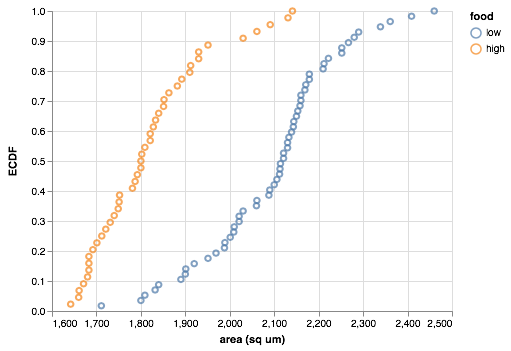

In [17]:
df = pd.read_csv('../data/c_elegans_egg_xa.csv', comment='#')

altcat.catplot(data=df,
               mark='point',
               encoding={'x': alt.X('area (sq um):Q', scale=alt.Scale(zero=False)),
                         'color': alt.Color('food:N', sort=['low', 'high'])},
               transform='ecdf')

For the present analysis, we will consider the low food treatment. For convenience, I will extract just the low food measurments into a Numpy array.

In [18]:
x = df.loc[df['food']=='low', 'area (sq um)'].values

# How many data points
len(x)

57

We have 57 measurements, and, as we have been doing, we will assume that the data are generated from a Gaussian distribution. We can then *simulate* the data generation process by drawing 57 samples out of a Gaussian distribution. In so doing, we can see how we might expect the results from the experiment to vary if we were to do it again. So, let's generate a data set and see how its ECDF looks. We will assume parameters $\mu = 2000$ µm² and $\sigma = 200$ µm².

In [19]:
x_gen = np.random.normal(2000, 200, size=len(x))

Now let's make a plot of the two ECDFs side by side to make a comparison.

In [20]:
p = bebi103.viz.ecdf(x, x_axis_label='x (µm²)', formal=True, line_width=2)
p = bebi103.viz.ecdf(x_gen, p=p, color='gray', formal=True, line_width=2)

bokeh.io.show(p)

There seems to be a separation between the ECDFs. Let's try making many data sets from the generative distribution.

In [21]:
p = bebi103.viz.ecdf(x_gen, x_axis_label='x (µm²)', color='gray', alpha=0.1, formal=True)
 
for _ in range(100):
    x_gen = np.random.normal(2000, 200, size=len(x))
    p = bebi103.viz.ecdf(x_gen, p=p, color='gray', alpha=0.1, formal=True)
    
p = bebi103.viz.ecdf(x, p=p, formal=True, line_width=2)

bokeh.io.show(p)

In comparing the ECDFs, we see that the generative model we have proposed cannot produce the data set we have observed. We could try adjusting our generative model by changing the parameters *µ* and *σ*. We will use the **maximum likelihood estimates** (we'll learn more about maximum likelihood estimates in coming weeks) for these, given by the mean and standard deviation from the data set itself.

In [22]:
mu = x.mean()
sigma = x.std()

# Make the draws and make the plot
x_gen = np.random.normal(mu, sigma, size=len(x))

p = bebi103.viz.ecdf(x_gen, x_axis_label='x (µm²)', color='gray', alpha=0.1, formal=True)
 
for _ in range(100):
    x_gen = np.random.normal(mu, sigma, size=len(x))
    p = bebi103.viz.ecdf(x_gen, p=p, color='gray', alpha=0.1, formal=True)
    
p = bebi103.viz.ecdf(x, p=p, formal=True, line_width=2)

bokeh.io.show(p)

With these parameter values, we see that the generative process we have proposed is more reasonable. 

For fun, let's do the same analysis with the high food data.

In [23]:
x = df.loc[df['food']=='high', 'area (sq um)'].values

mu = x.mean()
sigma = x.std()

# Make the draws and make the plot
x_gen = np.random.normal(mu, sigma, size=len(x))

p = bebi103.viz.ecdf(x_gen, x_axis_label='x (µm²)', color='gray', alpha=0.1, formal=True)
 
for _ in range(100):
    x_gen = np.random.normal(mu, sigma, size=len(x))
    p = bebi103.viz.ecdf(x_gen, p=p, color='gray', alpha=0.1, formal=True)
    
p = bebi103.viz.ecdf(x, p=p, formal=True, line_width=2, color='orange')

bokeh.io.show(p)

In this case, too, it is reasonable that the data are Gaussian distributed.

In this example, we have generated an ECDF for each generated data set. We could instead generate any other summary statistic, such as a mean or median.

In [24]:
# Generate medians
medians = np.array([np.median(np.random.normal(mu, sigma, size=len(x))) for _ in range(1000)])

# Plot ECDF of medians
bokeh.io.show(bebi103.viz.ecdf(medians, x_axis_label='x (µm²)', y_axis_label='ECDF of medians'))

In we can expect the median cross-sectional area to be about 1825 µm², and vary from about 1775 to 1860 µm²

This procedure we have just done, where we use a generative model to create data sets and check summaries of them, like ECDFs medians, is called **parametric bootstrapping**. We will use it extensively throughout the entire course to see what kind of data sets may be arise from our generative models. In the next tutorial, we will use bootstrapping (primarily nonparametric bootstrapping) to do statistical inference under the frequentist paradigm.

## Installing Stan

Installing Stan can be a bit tricky. First off, there are known issues with PyStan 2.18 with Anaconda distributions. As of October 15, [these issues may be fixed using the conda-forge channel](https://github.com/stan-dev/pystan/issues/414). Nonetheless, for this reason, these instructions are for installing Stan 2.17. Secondly, [PyStan is only partially supported under Windows](https://pystan.readthedocs.io/en/latest/windows.html). You can attempt to install Stan using the following instructions, but you can also simply [use AWS for your computing](aux4_AWS.html). PyStan 2.18 is installed and working if you use the BE/Bi 103 AMI.

#### Installation on macOS and Linux

To install PyStan 2.17 on macOS or Linux, do the following on the command line.

    conda install pystan=2.17.1.0

#### Installation on Windows

You first need to install a compiler than Stan can use, since it cannot use the MSVC compiler.

    conda install libpython m2w64-toolchain -c msys2
    
Then, you can install PyStan

    conda install pystan=2.17.1.0
    
If you have problems, you may consult the [PyStan documentation](https://pystan.readthedocs.io/en/latest/windows.html) or just forget it and use AWS.

In [25]:
%load_ext watermark

In [26]:
%watermark -v -p numpy,pandas,scipy,pystan,altair,altair_catplot,bokeh,bebi103,jupyterlab

CPython 3.7.0
IPython 7.0.1

numpy 1.15.2
pandas 0.23.4
scipy 1.1.0
pystan 2.17.1.0
altair 2.2.2
altair_catplot 0.0.5
bokeh 1.0.0
bebi103 0.0.31
jupyterlab 0.35.1
